#Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, InputLayer
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy import signal
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
import pdb

In [2]:
q = 100            # L/min
Ti = 350           # K
cA_i = 1           # mol/L
V = 100            # L
rho = 1000         # g/L
C = 0.239          # J/(g K)
Hr = -5e4          # J/(g K)
E_over_r = 8750    # K
k0 = 7.2e10        # min^(-1)
UA = 5e4           # J/(min K)
Tc = Tc0 = 300     # K

In [3]:
# simulation run time: 60 min (1 hr)

tspan = (0, 60)
t = np.linspace(*tspan, 1000) 

In [4]:
# Add steady state values

Ca0 = 0.5    #mol/L
T0 = 350.0   #K

# pdb.set_trace()

# Generating a noise array
length = len(t)
noise = 0.001*np.random.randn(length)

# defining the reactor model
def simulation_model(t,x):
    Ca = x[0]
    T = x[1]
    k = k0*np.exp(-E_over_r/T)
    w = q*rho
    dcAdt = q*(cA_i - Ca)/V - k*Ca
    dTdt = 1/(V*rho*C)*(w*C*(Ti - T) - Hr*V*k*Ca + UA*(Tc - T))
    return dcAdt, dTdt
  

In [5]:
# Initial Conditions
y0 = [Ca0, T0]

In [6]:
simulation_model(0,y0)

(3.40208612952253e-05, -0.007117334999003795)

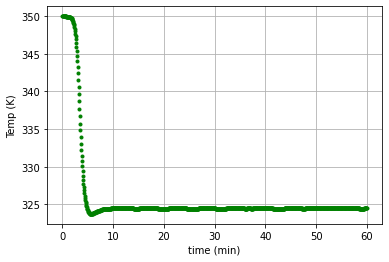

In [7]:
def simulate():
    res = solve_ivp(simulation_model, tspan, y0, t_eval=t)
    return res.y


#cA = res
#T = res
#print(cA,T)

Ca,T = simulate()

plt.plot(t, T, 'g.')
plt.ylabel('Temp (K)')
plt.xlabel("time (min)")  
plt.grid()
plt.show()


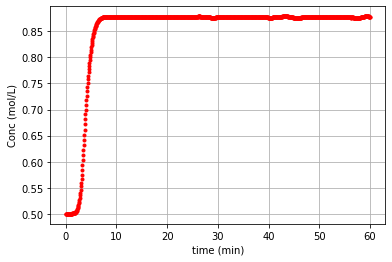

In [8]:
plt.plot(t, Ca, 'r.')
plt.ylabel('Conc (mol/L)')
plt.xlabel("time (min)")  
plt.grid()
plt.show()

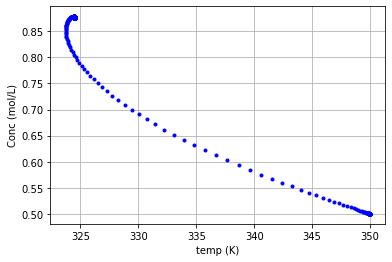

In [9]:
plt.plot(T, Ca, 'b.')
plt.ylabel('Conc (mol/L)')
plt.xlabel("temp (K)")  
plt.grid()
plt.show()

In [10]:
# Concentartion after adding noise
conc = Ca + noise
temp = T + noise
print(Ca)
print(conc.ndim)
print(t.ndim)
#Extracting Independent and dependent Variable  
x1= t
y1= conc
#import pdb
#pdb.set_trace()
x2 = x1.reshape(-1,1)

[0.5        0.5000024  0.50000559 0.50000969 0.50001487 0.50002132
 0.5000293  0.50003908 0.50005098 0.50006653 0.50010366 0.50016178
 0.50023338 0.50031205 0.5003925  0.50047059 0.50054327 0.50060862
 0.50066585 0.50071527 0.50075834 0.50079761 0.50083678 0.50088065
 0.50093515 0.50100732 0.50110535 0.50123851 0.50141722 0.50165301
 0.50195854 0.50234758 0.50283502 0.50343689 0.50417031 0.50505354
 0.50610597 0.5073481  0.50880153 0.51048903 0.51243444 0.51466275
 0.51720006 0.52007103 0.52326348 0.52684026 0.53088028 0.53544616
 0.54058416 0.54632422 0.55267998 0.55964873 0.56721143 0.57533274
 0.58396098 0.59302814 0.60244989 0.61212558 0.62193822 0.63179701
 0.64172819 0.65167925 0.66159481 0.67142468 0.68112392 0.69065275
 0.69997662 0.70906621 0.71789737 0.72645119 0.73471393 0.74267711
 0.75033742 0.75769676 0.76476151 0.77147915 0.77783935 0.7838771
 0.78962327 0.79510463 0.80034382 0.80535937 0.81016569 0.81477308
 0.81918773 0.8234117  0.82744295 0.83127531 0.83489851 0.83829

In [11]:
#Fitting the Polynomial regression to the dataset
x_ = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x2)
model = LinearRegression().fit(x_, y1)
intercept, coefficients = model.intercept_, model.coef_
y_pred = model.predict(x_)

r_sq = model.score(x_, y1)
print(r_sq)
#model = LinearRegression().fit(x2, y1)
#y_pred = model.intercept_ + model.coef_ * x2
#y_new = model.predict(x1)
# Construct results and save data file
#data = np.vstack((t,Caf,Ca,T)) # vertical stack
#data = data.T             # transpose data
#np.savetxt('data.txt',data,delimiter=',')

0.7175475956046031


In [12]:
# Computing MAE between the simulated data and the noise-added data
print('MAE of the simulation is (using regression) ' + str(np.round(mean_absolute_error(conc, y_pred), 5)))

MAE of the simulation is (using regression) 0.03394


In [13]:
cs = CubicSpline(t, conc)
cs1 = CubicSpline(t, temp)
conc_new = cs(x2)
temp_new = cs1(x2)

Do moving avg first then use cubic spline

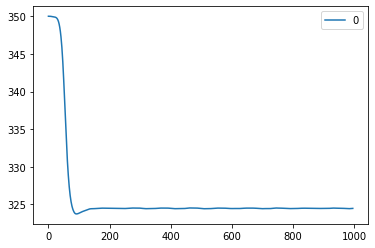

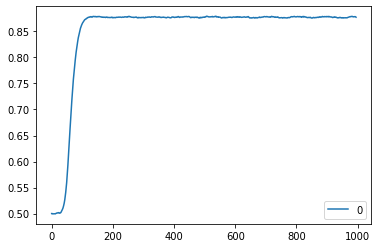

In [14]:
def moving_average(temp_avg, w):
    return np.convolve(temp_avg[:,0], np.ones(w), 'valid') / w

def moving_average(conc_avg, w):
    return np.convolve(conc_avg[:,0], np.ones(w), 'valid') / w

def moving_average(t_avg, w):
    return np.convolve(t_avg[:,0], np.ones(w), 'valid') / w


# print(moving_average(temp_new, 5))
pd.DataFrame(moving_average(temp_new, 5)).plot()
pd.DataFrame(moving_average(conc_new, 5)).plot()

In [15]:
conc_avg = moving_average(conc_new, 5)
temp_avg = moving_average(temp_new, 5)
print(t.shape)
print(temp_avg.shape)
print(conc_avg.shape)
t_avg = moving_average(t.reshape(-1,1), 5)

(1000,)
(996,)
(996,)


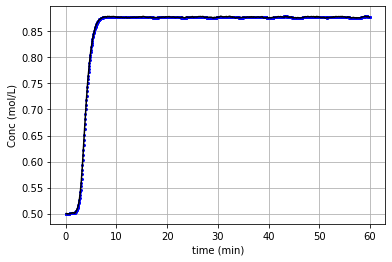

In [16]:
# Plot the inputs and results
#plt.plot(t,Ca,'r-',label='Ca')
#plt.plot(t_sys,Ca_sys,'g--',label='Ca (State Space)')

#plt.legend(loc='best')
#plt.grid()

#print(t)
#print(conc)
# t2 = t_avg.reshape(-1,1)

# t_avg = np.ma.masked_equal(t2,0)
#conc_avg = np.ma.masked_equal(conc_avg,0)
#temp_avg = np.ma.masked_equal(temp_avg,0)

#Visulaizing the result for Polynomial Regression  
#plt.plot(t_sys,conc,'b--', markersize=2, label='Ca (with noise- simul)')
#plt.plot(x2, y_pred, color="orange")
#plt.plot(t2, conc_avg, color="violet")
# plt.plot(t,conc,'bo', markersize=2, label='Ca (with noise- simul)')

plt.plot(t,Ca,'bo', markersize=2)
plt.plot(t_avg,conc_avg,'k-', markersize=2)
plt.ylabel('Conc (mol/L)')
plt.xlabel("time (min)")  
plt.grid()

plt.show()

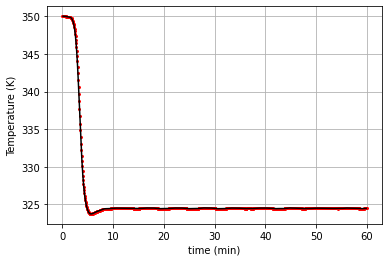

In [17]:
plt.plot(t,temp,'ro', markersize=2, label='Ca (with noise- simul)')
plt.plot(t_avg,temp_avg,'k-', markersize=2)
plt.ylabel('Temperature (K)')
#plt.title("(Polynomial Regression)")  
plt.xlabel("time (min)")  
#plt.ylabel("conc")
plt.grid()

plt.show()

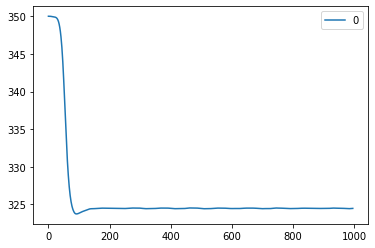

In [18]:
pd.DataFrame(temp_avg).plot()

In [19]:
temp_avg

array([349.9990187 , 349.99841209, 349.99716812, 349.99571797,
       349.99452802, 349.99295195, 349.99091164, 349.98741695,
       349.98289495, 349.97644767, 349.96869975, 349.95990005,
       349.95117888, 349.94287842, 349.93479893, 349.9275666 ,
       349.92091116, 349.91431307, 349.90834599, 349.90218006,
       349.89568229, 349.88796659, 349.87780653, 349.86418052,
       349.84725399, 349.82480795, 349.79556038, 349.75903466,
       349.71318511, 349.65583464, 349.58525094, 349.50029817,
       349.39810056, 349.27616357, 349.13199452, 348.96353053,
       348.76779121, 348.54198621, 348.28350741, 347.98926607,
       347.65635722, 347.2821528 , 346.86240734, 346.39361596,
       345.87116569, 345.29040507, 344.6488345 , 343.94609827,
       343.18265209, 342.3632168 , 341.49354404, 340.58019825,
       339.63386939, 338.66640159, 337.69143823, 336.7238483 ,
       335.77515543, 334.85351061, 333.96534539, 333.11392824,
       332.29970384, 331.52595298, 330.79475805, 330.10

In [20]:
xscaler = MinMaxScaler()
yscaler = MinMaxScaler()

X = xscaler.fit_transform(temp_avg.reshape(temp_avg.shape[0], 1))
Y = yscaler.fit_transform(conc_avg.reshape(conc_avg.shape[0], 1))

print(xscaler.data_min_)

[323.7350724]


In [21]:
pd.DataFrame(X).describe()

,0
count,996.000000
mean,0.080763
std,0.208670
min,0.000000
25%,0.027115
50%,0.028112
75%,0.029129
max,1.000000


In [22]:
d = pd.DataFrame(temp_avg, columns=["T"])
d[d["T"] == 0].count()

T    0
dtype: int64

In [23]:
# # inputs and outputs
# x_in = pd.DataFrame(np.array(temp_avg), columns=["T"])        # input: the simulation time series
# x_out = pd.DataFrame(np.array(conc_avg), columns=["C"])   # output: difference between measurement and simulation

# split into train-test set
x_train, x_test, y_train, y_test= train_test_split(X, Y, test_size= 0.33, random_state=1)  

# x_train = x_train.reshape(x_train.shape + (1,))
# y_train = y_train.reshape(y_train.shape + (1,))

# x_test = x_test.reshape(x_test.shape + (1,))
# y_test = y_test.reshape(y_test.shape + (1,))

# check shapes
print('shape of X_train is: ' + str(x_train.shape) + '; shape of y_train is: ' + str(y_train.shape))
print('shape of Y_test is: ' + str(y_test.shape) + '; shape of y_test is: ' + str(y_test.shape))

shape of X_train is: (667, 1); shape of y_train is: (667, 1)
shape of Y_test is: (329, 1); shape of y_test is: (329, 1)


                0
count  667.000000
mean     0.079546
std      0.207818
min      0.000000
25%      0.027080
50%      0.028032
75%      0.029130
max      0.999977


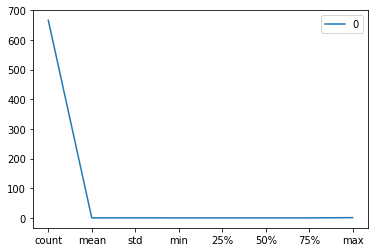

In [24]:
df1 = pd.DataFrame(x_train).describe()
print(df1)
ax1 = df1.plot()

                0
count  667.000000
mean     0.932381
std      0.224194
min      0.000000
25%      0.993031
50%      0.994956
75%      0.996708
max      1.000000


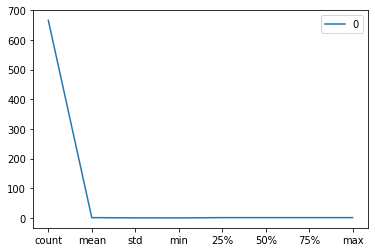

In [25]:
df2 = pd.DataFrame(y_train).describe()
print(df2)
ax2 = df2.plot()

In [ ]:
# making a simple neural network model
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

epochs = 100
loss = "mse"
model.compile(optimizer='adam',
              loss=loss,
              metrics=['mae'], #Mean Absolute Error
             )
history = model.fit(x_train, y_train, 
                    shuffle=True, 
                    epochs=epochs,
                    batch_size=20,
                    validation_split =.2, 
                    verbose=2)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


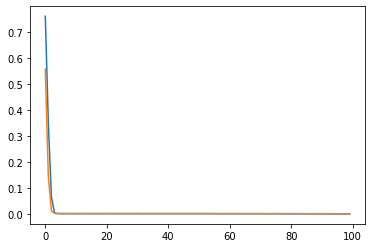

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
history.history

In [30]:
result = model.predict(x_test)
# X:      0 2 1 8 9
# Y:       2 3 4 5 6
# Y_pred:  1 2 3 4 5

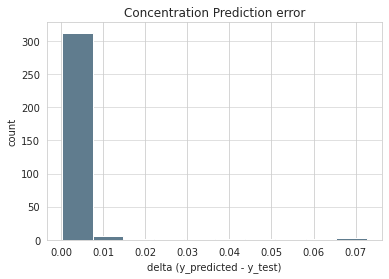

In [101]:
result_unscaled = yscaler.inverse_transform(result)
y_test_unscaled = yscaler.inverse_transform(y_test)
x_test_unscaled = yscaler.inverse_transform(x_test)
#pd.DataFrame(result_unscaled - y_test_unscaled).abs().describe()

pd.DataFrame(result_unscaled - y_test_unscaled).abs().hist(color='#607c8e', grid=True)
plt.title('Concentration Prediction error')
plt.xlabel('delta (y_predicted - y_test)')
plt.ylabel('count')
plt.grid(axis='y', alpha=0.75)
#plt.plot([i for i in range(len(result_unscaled))], result_unscaled, y_test_unscaled)

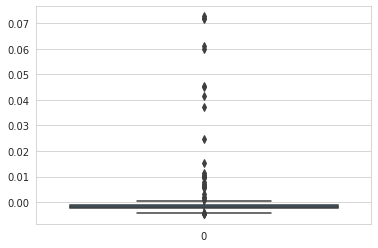

In [68]:
res = pd.DataFrame(result_unscaled - y_test_unscaled)
import seaborn as sns
sns.set_style("whitegrid")
sns.boxplot(data = res)


In [32]:
model.evaluate(x_test,  y_test, verbose=2)

11/11 - 0s - loss: 6.9691e-04 - mae: 0.0098 - 86ms/epoch - 8ms/step


[0.0006969095556996763, 0.009838737547397614]

In [33]:
mean_absolute_error(y_test_unscaled, result_unscaled)

0.003734563408778198

In [34]:
# RMSE
mean_squared_error(y_test_unscaled, result_unscaled)
np.sqrt(mean_squared_error(y_test_unscaled, result_unscaled))

0.010020470186825895

In [35]:
# R-squared
r2_score(y_test_unscaled, result_unscaled)

0.986926953199646

In [36]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


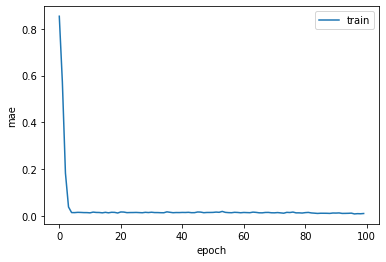

In [37]:
plt.plot(history.history['mae'])
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train'], loc='best')
plt.show()

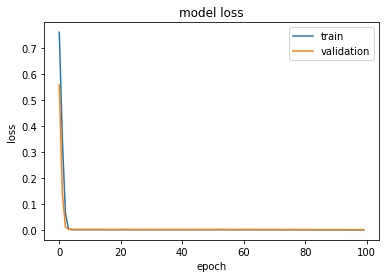

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

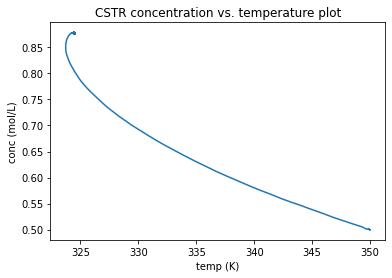

In [39]:
plt.plot(temp_avg, conc_avg)
plt.title('CSTR concentration vs. temperature plot')
plt.ylabel('conc (mol/L)')
plt.xlabel('temp (K)')
plt.show()

2
1
2
1


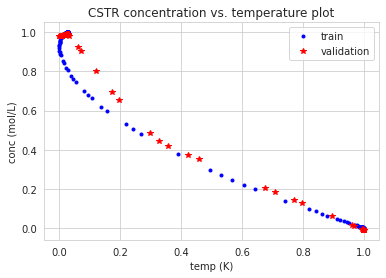

In [97]:
#plt.plot(temp_avg, conc_avg, 'r.')
plt.plot(x_train, y_train, 'b.')
plt.plot(x_test, result, 'r*')
print(x_test_unscaled.ndim)
print(temp_avg.ndim)
print(result_unscaled.ndim)
print(conc_avg.ndim)
#plt.plot(temp_avg, conc_avg, 'r.')
plt.title('CSTR concentration vs. temperature plot')
plt.ylabel('conc (mol/L)')
plt.xlabel('temp (K)')
plt.legend(['train', 'validation'], loc='best')
plt.show()

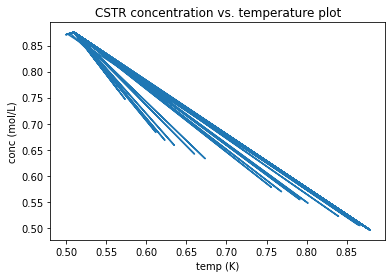

In [41]:
plt.plot(x_test_unscaled, result_unscaled)
plt.title('CSTR concentration vs. temperature plot')
plt.ylabel('conc (mol/L)')
plt.xlabel('temp (K)')
plt.show()

In [ ]:
# X (temp):      0 2 1 8 9
# Y (conc):       2 3 4 5 6
# Y_pred (conc):  1 2 3 4 5

boxplot (abs_delta), histogram(sns - delta)